# Predição de mortalidade em internações por pneumonias bacterianas sensíveis à Atenção Primária no Brasil, 2017-2021

## Análise Exploratória

### 1. Importando dados

In [1]:
# IMPORTANDO PACOTES 
import matplotlib as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd  
import chart_studio.plotly as py
import plotly.graph_objs as gp 
import seaborn as sns

from sklearn.preprocessing import StandardScaler

In [2]:
#IMPORTANDO DADOS DE INTERNAÇÃO POR PNEUMONIA
colunas =  ["MORTE", "CID_MORTE", "DIAG_PRINC", "DT_INTER", "ANO_CMPT", "MES_CMPT", "DIAG_SECUN",  "IDADE", "SEXO", "UF_ZI", "DIAS_PERM", "NUM_FILHOS", "INSTRU", "MARCA_UTI", "INFEHOSP"]

sih_pneumo = pd.read_csv("sih_pneumonia_1721.csv")
sih_pneumo.set_axis(colunas, axis= 1, inplace= True)
sih_pneumo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997695 entries, 0 to 997694
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   MORTE       997695 non-null  int64  
 1   CID_MORTE   997695 non-null  int64  
 2   DIAG_PRINC  997695 non-null  object 
 3   DT_INTER    997695 non-null  int64  
 4   ANO_CMPT    997695 non-null  int64  
 5   MES_CMPT    997695 non-null  int64  
 6   DIAG_SECUN  997695 non-null  int64  
 7   IDADE       997695 non-null  int64  
 8   SEXO        997695 non-null  int64  
 9   UF_ZI       997695 non-null  int64  
 10  DIAS_PERM   997695 non-null  int64  
 11  NUM_FILHOS  997695 non-null  int64  
 12  INSTRU      997695 non-null  int64  
 13  MARCA_UTI   997695 non-null  int64  
 14  INFEHOSP    0 non-null       float64
dtypes: float64(1), int64(13), object(1)
memory usage: 114.2+ MB


In [3]:
#IMPORTANDO DADOS DE INTERNAÇÃO POR UF E ANO

internacoes_br = pd.read_csv("A110224189_28_143_208.csv", encoding= "UTF-8", sep = ";")
internacoes_br.rename(columns = {"Unidade da Federa��o":"UF"}, inplace= True)
internacoes_br["UF"] = internacoes_br["UF"].astype('str').str.extractall('(\d+)').unstack()
internacoes_br = internacoes_br[["UF", "2017", "2018", "2019", "2020", "2021", "2022"]]
internacoes_br.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   UF      27 non-null     object
 1   2017    28 non-null     int64 
 2   2018    28 non-null     int64 
 3   2019    28 non-null     int64 
 4   2020    28 non-null     int64 
 5   2021    28 non-null     int64 
 6   2022    28 non-null     int64 
dtypes: int64(6), object(1)
memory usage: 1.7+ KB


### 2. Preparando os dados

In [4]:
#VERIFICANDO DATAS DE INTERNAÇÃO
sih_pneumo['DT_INTER'] = sih_pneumo['DT_INTER'].astype("string")

sih_pneumo['ANO_INT'] = sih_pneumo['DT_INTER'].str.slice(0, 4)
sih_pneumo['ANO_INT'] = sih_pneumo['ANO_INT'].astype(int)
sih_pneumo['ANO_INT'].value_counts().sort_index()

2016      6966
2017    160694
2018    170708
2019    179618
2020     98501
2021    127483
2022    253725
Name: ANO_INT, dtype: int64

In [5]:
#VERIFICANDO ANO DE COMPETENCIA
sih_pneumo['ANO_CMPT'] = sih_pneumo['ANO_CMPT'].astype(int)
sih_pneumo['ANO_CMPT'].value_counts().sort_index()

2017    159417
2018    169893
2019    179769
2020    102449
2021     89492
2022    296675
Name: ANO_CMPT, dtype: int64

In [6]:
#FILTRANDO POR ANO DE INTERNAÇÃO´
anos = [2017, 2018, 2019, 2020, 2021]
sih_pneumo = sih_pneumo[sih_pneumo['ANO_INT'].isin(anos)]
sih_pneumo['ANO_INT'].value_counts().sort_index()

2017    160694
2018    170708
2019    179618
2020     98501
2021    127483
Name: ANO_INT, dtype: int64

#### 2.1 Identificando e classificando os dados

In [7]:
#IDENTIFICANDO OS DADOS
sih_pneumo2 = sih_pneumo.copy()
sih_pneumo2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737004 entries, 0 to 995245
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   MORTE       737004 non-null  int64  
 1   CID_MORTE   737004 non-null  int64  
 2   DIAG_PRINC  737004 non-null  object 
 3   DT_INTER    737004 non-null  string 
 4   ANO_CMPT    737004 non-null  int64  
 5   MES_CMPT    737004 non-null  int64  
 6   DIAG_SECUN  737004 non-null  int64  
 7   IDADE       737004 non-null  int64  
 8   SEXO        737004 non-null  int64  
 9   UF_ZI       737004 non-null  int64  
 10  DIAS_PERM   737004 non-null  int64  
 11  NUM_FILHOS  737004 non-null  int64  
 12  INSTRU      737004 non-null  int64  
 13  MARCA_UTI   737004 non-null  int64  
 14  INFEHOSP    0 non-null       float64
 15  ANO_INT     737004 non-null  int64  
dtypes: float64(1), int64(13), object(1), string(1)
memory usage: 95.6+ MB


In [8]:
#AJUSTANDO OS DADOS SEGUNDO O TIPO
sih_pneumo2['CID_MORTE'] = sih_pneumo2['CID_MORTE'].astype(str)
sih_pneumo2['DIAG_PRINC'] = sih_pneumo2['DIAG_PRINC'].astype(str)
sih_pneumo2['DIAG_SECUN'] = sih_pneumo2['DIAG_SECUN'].astype(str)
sih_pneumo2['UF_ZI'] = sih_pneumo2['UF_ZI'].astype(str)
sih_pneumo2['UF'] = sih_pneumo2['UF_ZI'].str.slice(0, 2)
sih_pneumo2['IDADE'] = sih_pneumo2['IDADE'].astype("float64")
sih_pneumo2['DT_INTER'] = pd.to_datetime(sih_pneumo2['DT_INTER'])

sih_pneumo2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737004 entries, 0 to 995245
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   MORTE       737004 non-null  int64         
 1   CID_MORTE   737004 non-null  object        
 2   DIAG_PRINC  737004 non-null  object        
 3   DT_INTER    737004 non-null  datetime64[ns]
 4   ANO_CMPT    737004 non-null  int64         
 5   MES_CMPT    737004 non-null  int64         
 6   DIAG_SECUN  737004 non-null  object        
 7   IDADE       737004 non-null  float64       
 8   SEXO        737004 non-null  int64         
 9   UF_ZI       737004 non-null  object        
 10  DIAS_PERM   737004 non-null  int64         
 11  NUM_FILHOS  737004 non-null  int64         
 12  INSTRU      737004 non-null  int64         
 13  MARCA_UTI   737004 non-null  int64         
 14  INFEHOSP    0 non-null       float64       
 15  ANO_INT     737004 non-null  int64         
 16  UF

In [9]:
#INCLUINDO NOME DAS CID NA VARIÁVEL DE DIAGNÓSTICO PRINCIPAL
dic_cid = {"J159": "J159 - Pneumonia bacteriana NE", "J158": "J158 - Pneumonia bacteriana NE", "J181": "J181 - Pneumonia lobar NE ",
 "J154": "J154 - Pneumonia por Streptococus", "J153": "J153 - Pneumonia por Streptococus", "J14": "J14 - Pneumonia por Haemophilus infuenzae",
 "J13": "J13 - Pneumonia Pneumocócica"}

sih_pneumo2['DIAG_PRINC'] = sih_pneumo2['DIAG_PRINC'].replace(dic_cid)

#### 2.2 *Missing values*

In [10]:
#EXCLUINDO VARIÁVEIS COM TODOS OS VALORES NULOS, VAZIOS OU ÚNICOS
sih_pneumo2.drop(['INFEHOSP', 'UF_ZI', 'NUM_FILHOS', 'INSTRU', 'CID_MORTE', 'DIAG_SECUN'], axis= 1, inplace= True)

#### 2.3 *Outliers*

In [11]:
#SELECIONANDO VARIÁVEIS QUE PODEM APRESENTAR OUTLIERS
sih_box = sih_pneumo2[['IDADE', 'DIAS_PERM']]

In [12]:
#TRANSFORMANDO DADOS PARA A MESMA ESCALA
scale = StandardScaler()

sih_box2 = pd.DataFrame(scale.fit_transform(sih_box))
sih_box2.set_axis(['IDADE', 'DIAS_PERM'], axis=1, inplace=True)
sih_box2 = pd.DataFrame(sih_box2.stack()).reset_index()
sih_box2.drop('level_0', axis = 1, inplace = True)
sih_box2.rename(columns = {'level_1':'variables', 0:'standard_value'}, inplace = True)

[Text(0.5, 0, 'Valores padronizados'),
 Text(0, 0.5, 'Variáveis'),
 Text(0.5, 1.0, 'Boxplot dias de permanência e idade padronizados')]

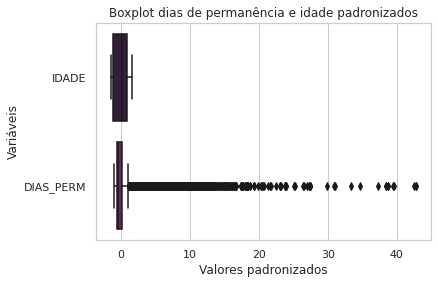

In [13]:
#GERANDO BOXPLOTS
sns.set(rc={'figure.figsize':(14, 10)})
sns.set_theme(style="whitegrid", palette="rocket")

box = sns.boxplot(y = "variables", x = "standard_value", data = sih_box2)
box.set(xlabel ="Valores padronizados", ylabel = "Variáveis", title ='Boxplot dias de permanência e idade padronizados')

In [14]:
#SELECIONANDO DADOS COM DISTRIBUIÇÃO MAIOR QUE -1.96 E MENOR QUE 1.96
sih_box = pd.DataFrame(sih_box.stack()).reset_index()
sih_box.drop('level_0', axis = 1, inplace = True)
sih_box.rename(columns = {'level_1':'variables_originals', 0:'value'}, inplace = True)

sih_box = pd.concat([sih_box.reset_index(drop=True), sih_box2.reset_index(drop=True)], axis=1)
sih_box = sih_box[(sih_box['standard_value'] >= -1.96) & (sih_box['standard_value'] <= 1.96)]

In [15]:
#SELECIONANDO VALORES MÍNIMOS E MÁXIMOS 
min_values = pd.DataFrame(sih_box.groupby('variables_originals')['value'].min())
max_values = pd.DataFrame(sih_box.groupby('variables_originals')['value'].max())

min_values, max_values

(                     value
 variables_originals       
 DIAS_PERM              0.0
 IDADE                  0.0,
                      value
 variables_originals       
 DIAS_PERM             22.0
 IDADE                 99.0)

In [16]:
sih_pneumo2 = sih_pneumo2[(sih_pneumo2['DIAS_PERM'] <= max_values.loc['DIAS_PERM', 'value']) & (sih_pneumo2['IDADE'] <= max_values.loc['IDADE', 'value'])]

[Text(0.5, 0, 'Valores'),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Boxplot dias de permanência')]

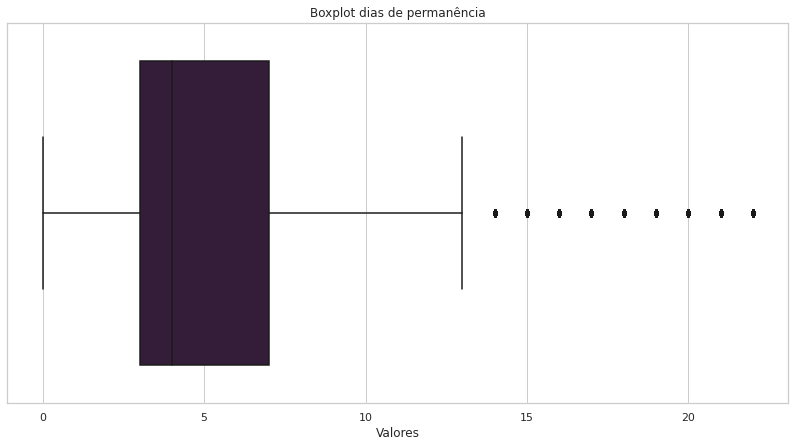

In [17]:
#GERANDO BOXPLOT DE DIAS DE PERMANÊNCIA
sns.set(rc={'figure.figsize':(14, 7)})
sns.set_theme(style="whitegrid", palette="rocket")

box1 = sns.boxplot(x = "DIAS_PERM", data = sih_pneumo2)
box1.set(xlabel ="Valores", ylabel = "", title ='Boxplot dias de permanência')


[Text(0.5, 20.200000000000003, 'Valores'),
 Text(20.200000000000003, 0.5, ''),
 Text(0.5, 1.0, 'Boxplot idade')]

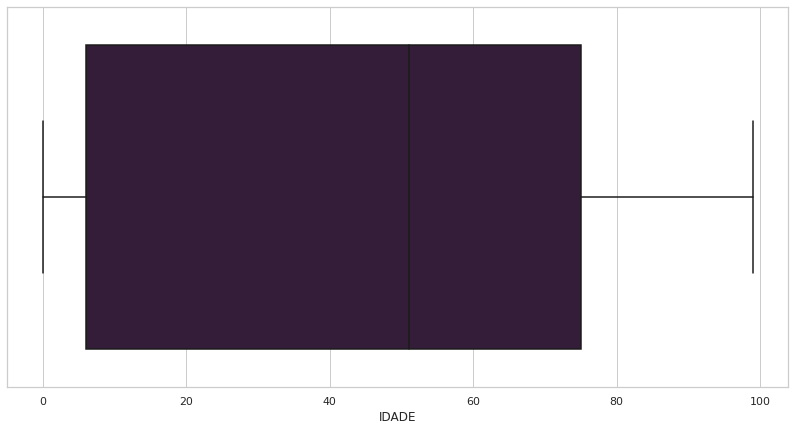

In [18]:
#GERANDO BOXPLOT DE IDADE
sns.set(rc={'figure.figsize':(14, 7)})
sns.set_theme(style="whitegrid", palette="rocket")

box2 = sns.boxplot(x = "IDADE", data = sih_pneumo2)
box.set(xlabel ="Valores", ylabel = "", title ='Boxplot idade')

## 3. Análise descritiva 

#### 3.1 Frequencia das variáveis

In [19]:
#NÚMERO DE INTERNAÇÕES ANTES E DEPOIS DA PREPARAÇÃO DA BASE
len(sih_pneumo), len(sih_pneumo2), (len(sih_pneumo)-len(sih_pneumo2))

(737004, 705916, 31088)

In [20]:
#FREQUENCIA DE INTERNAÇÕES POR SEXO
dic_sexo = {1:"Masculino", 3:"Feminino"}
sih_pneumo2["SEXO"] = sih_pneumo2["SEXO"].replace(dic_sexo)

sexo = pd.DataFrame(sih_pneumo2["SEXO"].value_counts())
sexo

,SEXO
Masculino,368843
Feminino,337073


In [21]:
#TABELA DE FREQUÊNCIA POR FAIXA ETÁRIA
sih_pneumo2["FAIXA_ETARIA"] = np.where(sih_pneumo2["IDADE"] <= 10, '0 - 10',
                              np.where(sih_pneumo2["IDADE"] < 20, '11-19',
                              np.where(sih_pneumo2["IDADE"] <= 60, '20-59', 
                              np.where(sih_pneumo2["IDADE"] <= 100, '60+',
                              'não informado'))))

In [22]:
#MORTALIDADE POR FAIXA ETÁRIA
mortalidade_por_fe = pd.DataFrame(pd.crosstab(sih_pneumo2["FAIXA_ETARIA"], sih_pneumo2["MORTE"], margins=True))
mortalidade_por_fe

MORTE,0,1,All
FAIXA_ETARIA,,,
0 - 10,229890,2166,232056
11-19,27420,484,27904
20-59,136118,11899,148017
60+,240170,57769,297939
All,633598,72318,705916


In [40]:
#PIRAMIDE ETÁRIA DAS INTERNAÇÕES
sexo_idade = pd.DataFrame(sih_pneumo2[["SEXO", "FAIXA_ETARIA"]])
sexo_idade["FREQUENCIA"] = 1
sexo_idade = pd.DataFrame(sexo_idade.groupby(["SEXO", "FAIXA_ETARIA"])["FREQUENCIA"].sum())
sexo_idade.reset_index(inplace=True)
sexo_idade = sexo_idade.pivot_table(index=["FAIXA_ETARIA"], 
                                    columns='SEXO', 
                                    values='FREQUENCIA')
sexo_idade.reset_index(inplace=True)
sexo_idade.index.names = ['index']

y_age = sexo_idade["FAIXA_ETARIA"]
x_F = sexo_idade["Feminino"]*-1
x_M = sexo_idade["Masculino"]

fig = gp.Figure()
fig.add_trace(gp.Bar(y= y_age, x = x_M, 
                     name = 'Masculino', 
                     orientation = 'h'))
fig.add_trace(gp.Bar(y = y_age, x = x_F,
                     name = 'Feminino', orientation = 'h',
                    ))
fig.update_layout(title = 'Número de internações por sexo e faixa etária, Brasil, 2017-2021',
                 title_font_size = 22, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0,
                 xaxis = dict(                                
                              title = 'Frequência',
                              title_font_size = 14)
                 ) 
fig.show()

In [25]:
#NÚMERO DE MORTES REGISTRADAS POR ANO
mortes_por_ano = pd.DataFrame(pd.crosstab(sih_pneumo2['MORTE'], sih_pneumo2['ANO_INT'], margins=True))
mortes_por_ano

ANO_INT,2017,2018,2019,2020,2021,All
MORTE,,,,,,
0,141430,149668,156165,81728,104607,633598
1,13060,14622,16521,12594,15521,72318
All,154490,164290,172686,94322,120128,705916


In [26]:
#CID PRINCIPAL POR ANO
cid_por_ano = pd.DataFrame(pd.crosstab(sih_pneumo2['DIAG_PRINC'], sih_pneumo2['ANO_INT'], margins=True))
cid_por_ano

ANO_INT,2017,2018,2019,2020,2021,All
DIAG_PRINC,,,,,,
J13 - Pneumonia Pneumocócica,2638,2750,2413,1023,926,9750
J14 - Pneumonia por Haemophilus infuenzae,425,184,173,109,182,1073
J153 - Pneumonia por Streptococus,419,483,315,149,164,1530
J154 - Pneumonia por Streptococus,1392,1278,1159,494,526,4849
J158 - Pneumonia bacteriana NE,56673,57029,56928,30266,38761,239657
J159 - Pneumonia bacteriana NE,87543,97581,107207,59708,75506,427545
J181 - Pneumonia lobar NE,5400,4985,4491,2573,4063,21512
All,154490,164290,172686,94322,120128,705916


In [27]:
#MORTALIDADE POR CID
mortes_por_cid = pd.DataFrame(pd.crosstab(sih_pneumo2['MORTE'], sih_pneumo2['DIAG_PRINC'], margins=True))
mortes_por_cid

DIAG_PRINC,J13 - Pneumonia Pneumocócica,J14 - Pneumonia por Haemophilus infuenzae,J153 - Pneumonia por Streptococus,J154 - Pneumonia por Streptococus,J158 - Pneumonia bacteriana NE,J159 - Pneumonia bacteriana NE,J181 - Pneumonia lobar NE,All
MORTE,,,,,,,,
0,8762,1017,1289,4489,218408,380418,19215,633598
1,988,56,241,360,21249,47127,2297,72318
All,9750,1073,1530,4849,239657,427545,21512,705916


#### 3.2 Medidas resumo 

#### 3.3 Calculando taxas

In [28]:
#LETALIDADE POR CID
mortalidade_por_cid = pd.DataFrame((mortes_por_cid.loc[1,]/cid_por_ano["All"]*100).round(2))
mortalidade_por_cid.reset_index(inplace= True)
mortalidade_por_cid.rename(columns= {0: "LETALIDADE"}, inplace= True)
mortalidade_por_cid

,DIAG_PRINC,LETALIDADE
0,J13 - Pneumonia Pneumocócica,10.13
1,J14 - Pneumonia por Haemophilus infuenzae,5.22
2,J153 - Pneumonia por Streptococus,15.75
3,J154 - Pneumonia por Streptococus,7.42
4,J158 - Pneumonia bacteriana NE,8.87
5,J159 - Pneumonia bacteriana NE,11.02
6,J181 - Pneumonia lobar NE,10.68
7,All,10.24


[Text(0.5, 0, 'Taxa de letalidade por internação'),
 Text(0, 0.5, 'Diagnóstico principal'),
 Text(0.5, 1.0, 'Letalidade por internações por cid específica por pneumonia sensível à APS, Brasil, 2017 a 2021')]

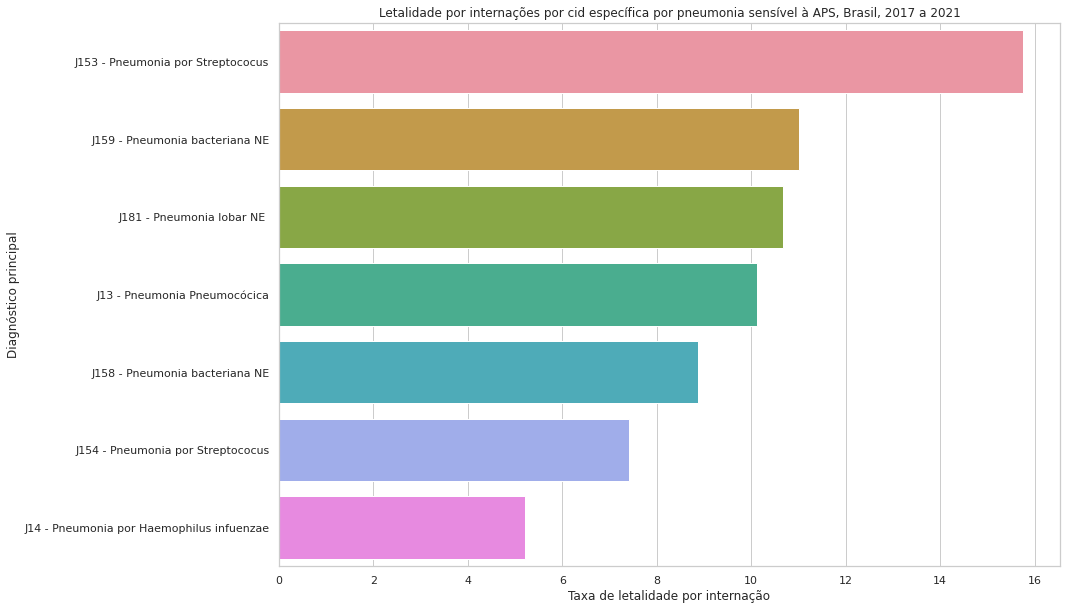

In [29]:
#GRÁFICO DE BARRAS POR CID
mortalidade_por_cid2 = mortalidade_por_cid.loc[0:6,]

sns.set(rc={'figure.figsize':(14, 10)})
sns.set_theme(style="whitegrid", palette="rocket")

order = mortalidade_por_cid2.groupby('DIAG_PRINC')['LETALIDADE'].sum().sort_values(ascending=False).index.values

bar = sns.barplot(x = "LETALIDADE", y = "DIAG_PRINC", data = mortalidade_por_cid2, order = order)
bar.set(xlabel ="Taxa de letalidade por internação", ylabel = "Diagnóstico principal", title ='Letalidade por internações por cid específica por pneumonia sensível à APS, Brasil, 2017 a 2021')

In [30]:
#LETALIDADE POR INTERNAÇÕES
letal_por_ano = pd.DataFrame((mortes_por_ano.loc[1,]/cid_por_ano.loc["All",]*100).round(2))
letal_por_ano.reset_index(inplace= True)
letal_por_ano.rename(columns= {0: "LETALIDADE"}, inplace= True)
letal_por_ano

,ANO_INT,LETALIDADE
0,2017,8.45
1,2018,8.90
2,2019,9.57
3,2020,13.35
4,2021,12.92
5,All,10.24


/tmp/ipykernel_17315/1779464746.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[[<matplotlib.axis.XTick at 0x7f4b85b0d4c0>,

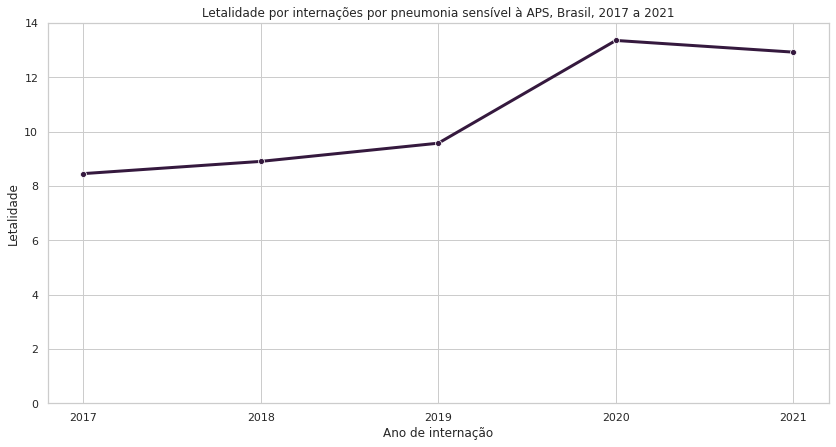

In [31]:
#GRÁFICO DE LETALIDADE POR ANO
letal_por_ano2 = letal_por_ano.loc[0:4,]
letal_por_ano2["ANO_INT"] = letal_por_ano2["ANO_INT"].astype("int64")

sns.set(rc={'figure.figsize':(14, 7)})
sns.set_theme(style="whitegrid", palette="rocket")

line = sns.lineplot(x = "ANO_INT", y = "LETALIDADE", linewidth = 3, marker='o', data = letal_por_ano2)
line.set(xlabel ="Ano de internação", ylabel = "Letalidade", title ='Letalidade por internações por pneumonia sensível à APS, Brasil, 2017 a 2021')
line.set(xticks=np.arange(2017,2022,1), yticks=np.arange(0,16,2))

In [32]:
#LETALIDADE PADRONIZADA POR FAIXA ETÁRIA
letal_por_fe = pd.DataFrame((mortalidade_por_fe[1]/mortalidade_por_fe['All']*100).round(2))
letal_por_fe.reset_index(inplace = True)
letal_por_fe.set_axis(["FAIXA_ETARIA", "LETALIDADE"], axis = 1, inplace = True)
letal_por_fe


,FAIXA_ETARIA,LETALIDADE
0,0 - 10,0.93
1,11-19,1.73
2,20-59,8.04
3,60+,19.39
4,All,10.24


[Text(0.5, 0, 'Taxa de letalidade por faixa etária'),
 Text(0, 0.5, 'Faixa etária'),
 Text(0.5, 1.0, 'Letalidade por internações por faixa etária por pneumonia sensível à APS, Brasil, 2017 a 2021')]

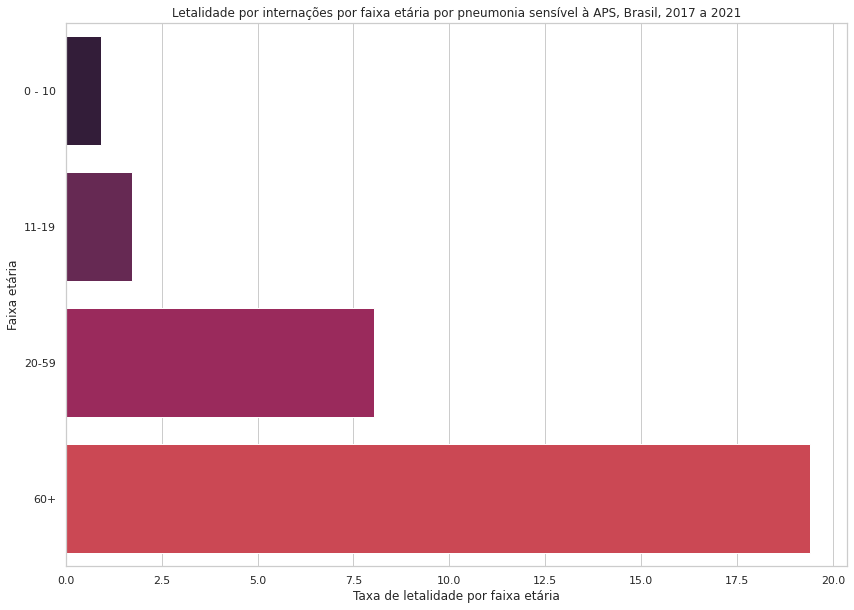

In [33]:
#GRÁFICO DE BARRAS POR CID
letal_por_fe = letal_por_fe.loc[0:3,]

sns.set(rc={'figure.figsize':(14, 10)})
sns.set_theme(style="whitegrid", palette="rocket")

bar2 = sns.barplot(x = "LETALIDADE", y = "FAIXA_ETARIA", data = letal_por_fe)
bar2.set(xlabel ="Taxa de letalidade por faixa etária", ylabel = "Faixa etária", title ='Letalidade por internações por faixa etária por pneumonia sensível à APS, Brasil, 2017 a 2021')

#### 3.4 Análise de correlação e associação das variáveis